<a href="https://colab.research.google.com/github/AngelGuadarrama/Consulta_DENUE/blob/main/extractor_denue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import numpy as np
import pandas as pd
import csv
from os import listdir
import re
from ipywidgets import interact, interact_manual
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words_sp = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extractor del Directorio Estadístico Nacional de Unidades Económicas (INEGI)

El objetivo es generar un programa, una base de datos o tabular, que le permita encontrar clientes para alianzas potenciales.

In [2]:
def capital(texto):
  words=texto.split(sep=' ')
  texto_cap=[word.capitalize() for word in words]
  resultado= " ".join(texto_cap)
  return resultado


def acentos(texto=""):
  words=texto.split(sep=' ')
  words=[re.sub(r"á", "a", word) for word in words]
  words=[re.sub(r"é", "e", word) for word in words]
  words=[re.sub(r"í", "i", word) for word in words]
  words=[re.sub(r"ó", "o", word) for word in words]
  words=[re.sub(r"ú", "u", word) for word in words]
  
  resultado= " ".join(words)
  return resultado

## Extractor y limpieza


*  Archivo compendio_total_contactable.txt (con | de separador) (carpeta de lectura y escritura)

*  Mensaje con tamaño, nombre de columnas y columnas faltantes

*  Filtrar por telefono/correo, compendio_total_contactable.txt

*  Quitar acentos, multiespacios y usar Capital()

In [7]:
@interact_manual
def compendio_total(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/', dir_out='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/'):
  global columnas_compendio
  
  csv_files=[file for file in listdir(dir_int) if file[-3:] == 'csv' and file[:5] == 'denue']
  #csv_files=["denue_inegi_16_.csv","denue_inegi_17_.csv","denue_inegi_13_.csv"]

  with open(dir_out+'compendio_total_contactable.txt', "w") as my_output_file: #Archivo txt
    columnas_compendio=[]

    for csv_file in csv_files: 
        print('Cargando archivo: '+csv_file)
        i=0 #Numero de filas (archivo inicial)
        j=0#Numero de filas (archivo limpio)

        with open(dir_int+csv_file, "r", encoding = "ISO-8859-1") as my_input_file: #Abre un archivo csv

            for row in csv.reader(my_input_file):

                if  i==0: #Encabezado
                   row.append('Ruta_Origen')
                   columnas=row
                   print('  Columnas: ', columnas)

                   if csv_files.index(csv_file) == 0: #Si es el primer archivo se agregan las columnas
                     columnas_compendio=columnas
                   else:
                     column_extra=list(set(columnas).difference(set(columnas_compendio)))
                     column_faltante=list(set(columnas_compendio).difference(set(columnas)))
                     #print('')
                     
                     print('Este archivo no contiene la(s) columna(s): ', column_extra)
                     print('Este archivo contiene ademas la(s) columna(s): ', column_faltante)
                     columnas_compendio+= column_extra

                   my_output_file.write("|".join(row)+'\n') #Separador y salto de linea

                else:
                   row.append(csv_file) #Ruta_Origen
                   
                   telefono= len( re.findall(r"\d{10}", row[columnas_compendio.index('telefono')]) ) != 0
                   correo= len( re.findall(r"@", row[columnas_compendio.index('correoelec')]) ) != 0

                   if i==1: print('  Primera Fila: ',row)

                   if telefono or correo:
                      row=[ capital(acentos( re.sub(r"\s+", " ",col ).lower() ) ) for col in row]
                      my_output_file.write("|".join(row)+'\n') #Separador y salto de linea

                      if j==1: print('  Primera Fila Limpia: ',row)
                      j+=1
                   
      
                i+=1  

        print('  Total de filas (archivo inicial): '+str(i)) 
        print('  Total de filas (archivo contactable): '+str(j)) 
        print('  Total de columnas: '+str(len(row)))  
        print('')
        print('')
    my_output_file.close()



  print('  Se ha creado el archivo compendio_total.txt exitosamente!')
  

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/', description='dir_i…

## Analisis de Negocio

El objetivo es hacer un análisis de la base de datos contactable, para enunciar al área de negocio los giros principales por entidad federativa.

*	Descriptivo crudo de todos los registros que contenga la palabra Banco o cualquier otra palabra clave para un negocio

El descriptivo debe enunciar al menos nombre de actividad y personal ocupado.
¿Qué otras variables puedes ser reelevantes?

Otras variables relevantes podrian ser raz_soc, tipo_vial y la entidad

In [47]:
@interact_manual
def cargar_compendio_limpio(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_contactable.txt', palabra='Banco', 
                            col_busqueda=['nom_estab', 'nombre_act'], col_cloud=['Nombre de Actividad', 'Nombre de Establecimiento']):
    global actividades
    global establecimientos
    global actividades_unicas
    global establecimientos_unicos

    with open(dir_int, "r") as file_clean:
        lines= file_clean.readlines()
        
        actividades=[]
        establecimientos=[]
        actividades_unicas=[]

        columnas_compendio=[]
        j=1

        for line in lines:  #Leemos las lineas del archivo compendio total
            row=line.split(sep="|")
            if row[0] == 'id': 
                columnas_compendio=row

            coincidencia= len( re.findall(palabra, row[columnas_compendio.index(col_busqueda)]) ) != 0

            if coincidencia :
                actividades.append(row[columnas_compendio.index('nombre_act')])
                establecimientos.append(row[columnas_compendio.index('nom_estab')])

                #print(j)
                #print('Nombre:', row[columnas_compendio.index('nom_estab')])
                #print('Actividad: ', row[columnas_compendio.index('nombre_act')])
                #print('Ocupacion: ', row[columnas_compendio.index('per_ocu')])
                #print('')
                j+=1              


        [actividades_unicas.append(x) for x in actividades if x not in actividades_unicas]

        print('Total de negocios: ', str(j-1))
        print('')

        if col_cloud == 'Nombre de Actividad': cloud=WordCloud(stopwords= stop_words_sp, max_font_size=40, random_state=2).generate(' '.join(actividades))
        if col_cloud == 'Nombre de Establecimiento': cloud=WordCloud(stopwords= stop_words_sp, max_font_size=40, random_state=2).generate(' '.join(establecimientos))

        fig=plt.figure(figsize=(20,10))
        plt.imshow(cloud)
        plt.axis('off')
        plt.show()

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_conta…

In [102]:
@interact_manual
def cargar_compendio_limpio(dir_int='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_contactable.txt', 
                            estado= ['Mexico','Michoacan De Ocampo','Hidalgo','Morelos','Puebla','Ciudad De Mexico'], 
                            col_cloud=['Nombre de Actividad', 'Nombre de Establecimiento']):
    global actividades
    global establecimientos
    global actividades_unicas
    global establecimientos_unicos
    global datos

    with open(dir_int, "r") as file_clean:
        lines= file_clean.readlines()
        
        actividades=[]
        establecimientos=[]
        actividades_unicas=[]
        rows=[]

        columnas_compendio=[]
        j=1
        telefono_count=1
        mail_count=1

        for line in lines:  #Leemos las lineas del archivo compendio total
            row=line.split(sep="|")
            if row[0] == 'id': 
                columnas_compendio=row

            coincidencia= len( re.findall(estado, row[columnas_compendio.index('entidad')]) ) != 0

            if coincidencia :
                rows.append(row)
                actividades.append(row[columnas_compendio.index('nombre_act')])
                establecimientos.append(row[columnas_compendio.index('nom_estab')])

                if row[columnas_compendio.index('telefono')] == '': telefono_count+=1
                if row[columnas_compendio.index('correoelec')] == '': mail_count+=1

                #print(j)
                #print('Nombre:', row[columnas_compendio.index('nom_estab')])
                #print('Actividad: ', row[columnas_compendio.index('nombre_act')])
                #print('Ocupacion: ', row[columnas_compendio.index('per_ocu')])
                #print('')
                
                
                j+=1              


        [actividades_unicas.append(x) for x in actividades if x not in actividades_unicas]

        print('Total de negocios en el estado de '+estado+':' ,str(j-1))
        print('Total de negocios con correo: ' ,str(telefono_count-1))
        print('Total de negocios con telefono: ' ,str(mail_count-1))
        print('')
        datos=pd.DataFrame(rows,  columns=columnas_compendio)

        if col_cloud == 'Nombre de Actividad': cloud=WordCloud(background_color='white',stopwords= stop_words_sp, random_state=2).generate(' '.join(actividades))
        if col_cloud == 'Nombre de Establecimiento': cloud=WordCloud(background_color='white',stopwords= stop_words_sp, random_state=2).generate(' '.join(establecimientos))

        fig=plt.figure(figsize=(15,5))
        plt.imshow(cloud)
        plt.axis('off')
        plt.show()

interactive(children=(Text(value='/content/drive/MyDrive/Colab Notebooks/Extractor_DENUE/compendio_total_conta…

Numero de Actividades unicas:  935


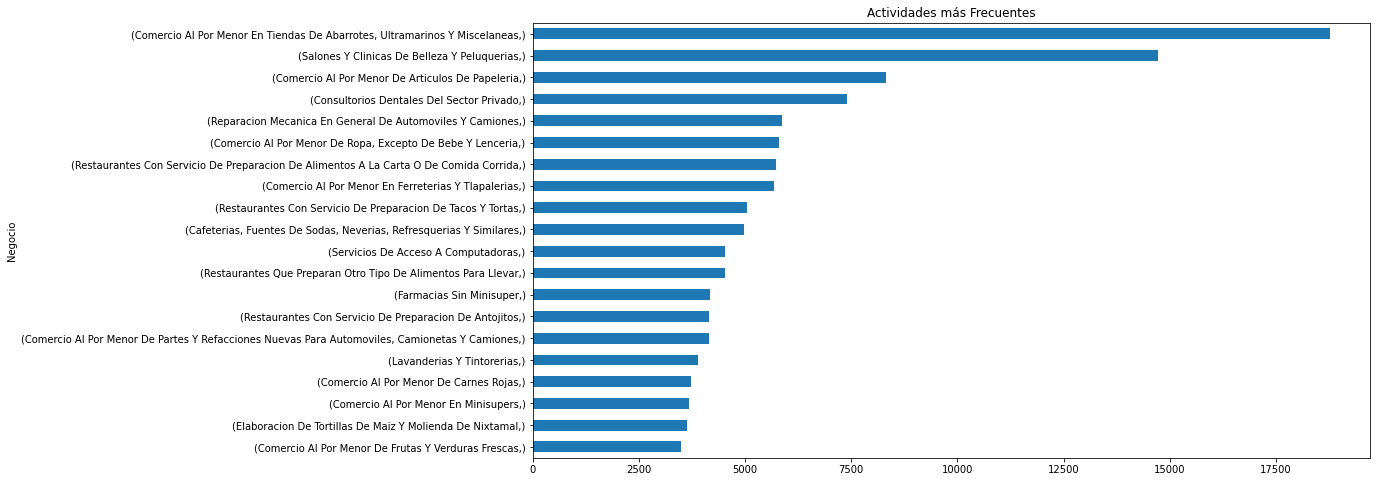

In [59]:
actividades_unicas=pd.DataFrame(actividades).value_counts().sort_values(ascending=True)
print('Numero de Actividades unicas: ', len(actividades_unicas))

plt.figure(figsize=(15,8))
actividades_unicas[-20:].plot(kind='barh', title='Actividades más Frecuentes', xlabel='Negocio', ylabel='Total de Negocios')
plt.show()


In [36]:
datos.columns

Index(['id', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act', 'per_ocu',
       'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1', 'tipo_v_e_2',
       'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext', 'letra_ext',
       'edificio', 'edificio_e', 'numero_int', 'letra_int', 'tipo_asent',
       'nomb_asent', 'tipoCenCom', 'nom_CenCom', 'num_local', 'cod_postal',
       'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc', 'localidad',
       'ageb', 'manzana', 'telefono', 'correoelec', 'www', 'tipoUniEco',
       'latitud', 'longitud', 'fecha_alta', 'Ruta_Origen\n'],
      dtype='object')

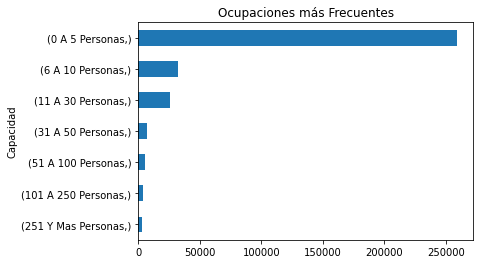

per_ocu           
0 A 5 Personas        259252
6 A 10 Personas        32278
11 A 30 Personas       25855
31 A 50 Personas        6690
51 A 100 Personas       5144
101 A 250 Personas      3741
251 Y Mas Personas      2585
dtype: int64


In [82]:
datos[['per_ocu']].value_counts(ascending=True).plot(kind='barh', title='Ocupaciones más Frecuentes', xlabel='Capacidad', ylabel='Total de Negocios')
plt.show()
print(datos[['per_ocu']].value_counts(ascending=False))

In [100]:
for x in datos[['per_ocu']].value_counts(ascending=False).index:
  actividades_per_ocup= datos[datos.per_ocu == x[0]]
  print('Actividades unicas con ocupacion de ', x[0], ': '+str(len(actividades_per_ocup.nombre_act.unique())))
  print('')

Actividades unicas con ocupacion de  0 A 5 Personas : 846

Actividades unicas con ocupacion de  6 A 10 Personas : 787

Actividades unicas con ocupacion de  11 A 30 Personas : 815

Actividades unicas con ocupacion de  31 A 50 Personas : 642

Actividades unicas con ocupacion de  51 A 100 Personas : 611

Actividades unicas con ocupacion de  101 A 250 Personas : 534

Actividades unicas con ocupacion de  251 Y Mas Personas : 437




Suponiendo que no tuvieramos el apoyo del campo de nombre de actividad, sería importante observar que sí sabemos de nuestros datos, por su contenido:

*  Hacer una diagrama de bi-palabras y un Ngram (2 o 3) para entender que tipo de servicios se van a promover por estado (todos) usando solo el nombre del establecimiento

* En el ejemplo no se ha hecho limpieza ¿Qué tipo de limpiezas se pueden hacer?  (ngram, count)

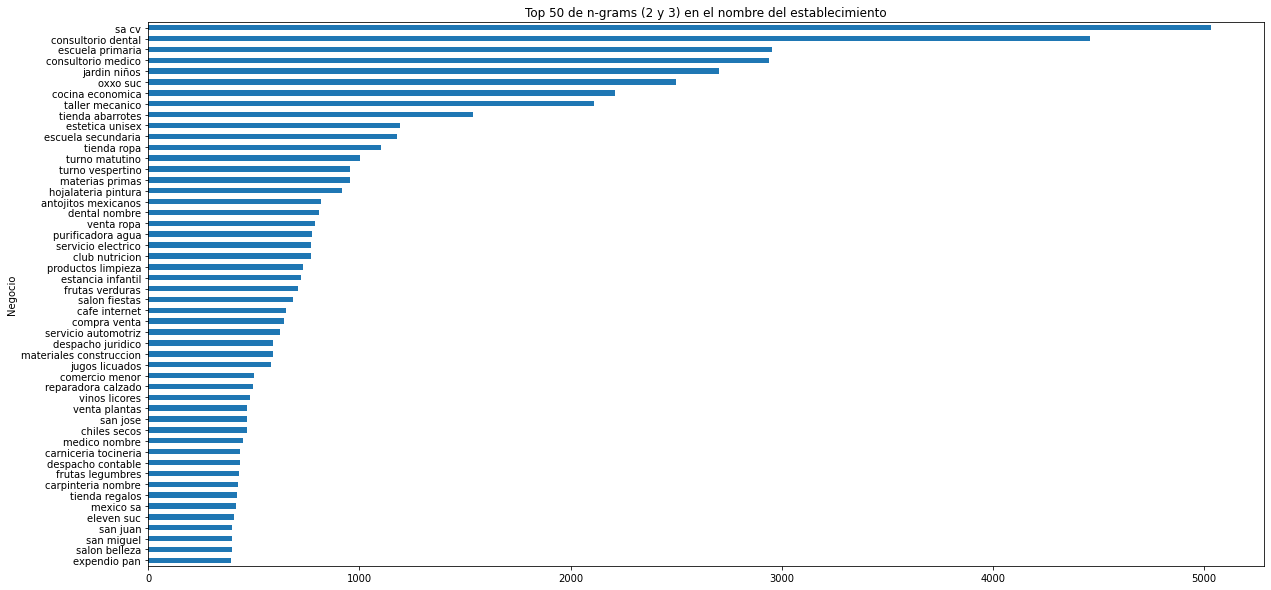

In [21]:
vect= CountVectorizer(max_features=50, 
                      stop_words=stop_words_sp, 
                      ngram_range=(2,2))

X=vect.fit_transform(pd.Series(establecimientos)) 

plt.figure(figsize=(20,10))
top_50_bi_tri_grams=pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
top_50_bi_tri_grams.sum().sort_values(ascending=True).plot(kind='barh', title='Top 50 de n-grams (2 y 3) en el nombre del establecimiento', 
                                                           xlabel='Negocio', ylabel='Total de Negocios')
plt.show()

In [17]:
top_50_bi_tri_grams.head()

,antojitos mexicanos,cafe internet,carniceria tocineria,carpinteria nombre,chiles secos,club nutricion,cocina economica,comercio menor,compra venta,consultorio dental,consultorio medico,dental nombre,despacho contable,despacho juridico,eleven suc,escuela primaria,escuela secundaria,estancia infantil,estetica unisex,expendio pan,frutas legumbres,frutas verduras,hojalateria pintura,jardin niños,jugos licuados,materiales construccion,materias primas,medico nombre,mexico sa,oxxo suc,productos limpieza,purificadora agua,reparadora calzado,sa cv,salon belleza,salon fiestas,san jose,san juan,san miguel,servicio automotriz,servicio electrico,taller mecanico,tienda abarrotes,tienda regalos,tienda ropa,turno matutino,turno vespertino,venta plantas,venta ropa,vinos licores
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
